In [112]:
!pip install torch torchvision -U

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [113]:
import torch
from torch import nn
from torch.utils.data import DataLoader,TensorDataset,random_split
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import torchvision
import numpy as np
import time, os, copy, random
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  2.0.0+cu117
Torchvision Version:  0.15.1+cu117


# Create artifical data
Set random seeds.

In [114]:
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

Set the number of batches and the batch size. For these early tests, 5 batches of size 3 should give good insights while not being to complicated.

In [115]:
n_batches = 10
n_train_batches = 7
batch_size = 4
n_samples = n_batches * batch_size

The network architecture, initial weights is similar to this source:
https://www.kaggle.com/code/sironghuang/understanding-pytorch-hooks.

In the linked notebook, only one datapoint is evaluated. Here, this datapoint will be repeated to include the effects of using batches.

In [116]:
artifical_data = torch.rand(size=(n_samples,2))
print(f'dataset size :{artifical_data.shape}')
print(f'single sample, size: {artifical_data[0,:].shape} | values: {artifical_data[0,:]}')

dataset size :torch.Size([40, 2])
single sample, size: torch.Size([2]) | values: tensor([0.4963, 0.7682])


In [117]:
artifical_labels = ((artifical_data[:,0]**2 + artifical_data[:,1]**2) < 0.7).int().unsqueeze(1)
print(f'label set size :{artifical_labels.shape}')
print(f'single label, size: {artifical_labels[0,:].shape} | values: {artifical_labels[0,:]}')

label set size :torch.Size([40, 1])
single label, size: torch.Size([1]) | values: tensor([0], dtype=torch.int32)


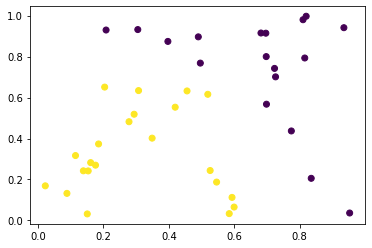

In [118]:
plt.scatter(artifical_data[:,0],artifical_data[:,1],c=artifical_labels[:,0])

Next, the datasets and dataloader are created from the tensors. The first 4*batch_size samples are being used as the training set and the remaining batch_size samples are the test set. The splitting of datasets is not necessary for now but will make extension easy later on.

Tensordata requires a 2D tensor, where each line represents one training sample. Targets may be 1-D or 2-D.

In [119]:
train_set = TensorDataset(artifical_data[:n_train_batches*batch_size,], artifical_labels[:n_train_batches*batch_size,])
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=False)
print(f'Number of datapoints in the training set is {len(train_set)}')

Number of datapoints in the training set is 28


In [120]:
eval_set = TensorDataset(artifical_data[n_train_batches*batch_size:,], artifical_labels[n_train_batches*batch_size:,])
eval_loader = DataLoader(train_set, batch_size=batch_size, shuffle=False)
print(f'Number of datapoints in the evaluation set is {len(eval_set)}')

Number of datapoints in the evaluation set is 12


In [121]:
dataloaders = {'train':train_loader,
               'eval':eval_loader}

# Create sample model
The base model architecture and weights are taken from [here](https://www.kaggle.com/code/sironghuang/understanding-pytorch-hooks) for reference.

In [122]:
class TestModel(nn.Module):
  def __init__(self, dropout_rate = 0.5):
        super().__init__()
        # self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(2,2)
        self.s1 = nn.Sigmoid()
        self.do1 = nn.Dropout(p=dropout_rate)
        self.fc2 = nn.Linear(2,1)
        self.s2 = nn.Sigmoid()

  def forward(self, x):
      # x = self.flatten(x)
      x= self.fc1(x)
      x = self.s1(x)
      x = self.do1(x)
      x= self.fc2(x)
      x = self.s2(x)
      return x

In [123]:
model = TestModel()
print(model)

TestModel(
  (fc1): Linear(in_features=2, out_features=2, bias=True)
  (s1): Sigmoid()
  (do1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=2, out_features=1, bias=True)
  (s2): Sigmoid()
)


In [124]:
for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

Layer: fc1.weight | Size: torch.Size([2, 2]) | Values : tensor([[-0.6590,  0.6283],
        [ 0.5377, -0.7054]], grad_fn=<SliceBackward0>) 

Layer: fc1.bias | Size: torch.Size([2]) | Values : tensor([ 0.1324, -0.1191], grad_fn=<SliceBackward0>) 

Layer: fc2.weight | Size: torch.Size([1, 2]) | Values : tensor([[-0.1164, -0.3237]], grad_fn=<SliceBackward0>) 

Layer: fc2.bias | Size: torch.Size([1]) | Values : tensor([0.2719], grad_fn=<SliceBackward0>) 



# Prepare pretraining optimizer and loss function

In [125]:
sgd_parameters = {
    'lr':1e-3,              # 1e-3
    'betas':(0.9,0.999),    # (0.9,0.999)
    'eps':1e-08,            # 1e-08
    'weight_decay':0.01     # 0.01
    # rest also standard
}
pretrain_optimizer = torch.optim.AdamW(model.parameters(), **sgd_parameters)

In [126]:
loss_fn = nn.BCELoss()

# Training Loop

In [127]:
def train_model(model, dataloaders, loss_fn, optimizer, num_epochs=5):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    n_train_batches = len(dataloaders['train'])

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        ########## train phase ##########
        phase = 'train'
        model.train()

        running_loss = 0.0
        running_corrects = 0

        for batch, (inputs, labels) in enumerate(dataloaders[phase]):
          model.train()
          optimizer.zero_grad()
          outputs = model(inputs)
          loss = loss_fn(outputs, labels.float())
          loss.backward()          
          optimizer.step()

          running_loss += loss.item() * inputs.size(0)
          preds = (outputs>0.5).int()
          running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(dataloaders[phase].dataset)
        epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
        print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

        ########## eval phase ##########
        phase = 'eval'
        model.eval()

        running_loss = 0.0
        running_corrects = 0

        for batch, (inputs, labels) in enumerate(dataloaders[phase]):
          # disable gradient tracking for speedup
          with torch.set_grad_enabled(phase == 'train'):
            outputs = model(inputs)
            loss = loss_fn(outputs, labels.float())
            preds = (outputs>0.5).int()

          running_loss += loss.item() * inputs.size(0)
          running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(dataloaders[phase].dataset)
        epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
        print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))  

        val_acc_history.append(epoch_acc)
        print()


    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    return val_acc_history

# Pretraining the model

In [134]:
hist = train_model(model,
                   dataloaders,
                   loss_fn,
                   pretrain_optimizer,
                   num_epochs=3
                   )

Epoch 0/2
----------
train Loss: 0.7030 Acc: 0.5000
eval Loss: 0.6926 Acc: 0.5357

Epoch 1/2
----------
train Loss: 0.6857 Acc: 0.5714
eval Loss: 0.6925 Acc: 0.5357

Epoch 2/2
----------
train Loss: 0.7224 Acc: 0.3214
eval Loss: 0.6924 Acc: 0.5357

Training complete in 0m 0s


# Getting infos about the state of the pretrained model + optimizer

In [135]:
pretrain_state = pretrain_optimizer.state
pretrain_state_dict = pretrain_optimizer.state_dict()

In [136]:
model.state_dict()

OrderedDict([('fc1.weight', tensor([[-0.6448,  0.6380],
                      [ 0.5475, -0.6980]])),
             ('fc1.bias', tensor([ 0.1176, -0.1313])),
             ('fc2.weight', tensor([[-0.1025, -0.3115]])),
             ('fc2.bias', tensor([0.2754]))])

In [137]:
pretrain_state_dict['state'][0]

{'step': tensor(42.), 'exp_avg': tensor([[-0.0025, -0.0021],
         [-0.0027, -0.0020]]), 'exp_avg_sq': tensor([[1.0687e-06, 1.3456e-06],
         [1.0527e-05, 9.4324e-06]])}

# Changes to make
- We need to correct the exp_avg from the pretrained model to the normalized one.